In [1]:
import os
import os.path
import time

import numpy as np
from skimage import io
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.utils.rnn import pack_padded_sequence
#from torchvision import transform

import editdistance
import IPython

# 1. Globals

In [3]:

# Symbol_set : only capitals
#symbol_set = ' .,?:;—!<>-«»()[]*"АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ0123456789'

# Symbol_set : both upper and lower case letters
symbol_set = ' .,?:;—!<>-«»()[]*"АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя0123456789'

# code for blank character
space_code = symbol_set.index(' ')

# data paths
raw_data_path ='raw_data/russian_news_corpus/'
source_file = 'russian_news.txt'
save_label_path = 'raw_data/synth_dataset/labels.txt'
save_img_path = 'raw_data/synth_dataset/images/'

# image_parameters
width = 360
height = 32

# maximum amount of characters on image
max_i = 18

# model_parameters
n_epochs = 12
expected_accuracy = 0.7

# parameter for recognition blank space betwten words.
# higher value -> lower blank_space sensitivity
letter_dist = 9

# parameter for recognition doulbled letters.
# higher value -> lower Dl sensitivity
double_sign = 5

# if true, incorrect spaces will not affect accuracy
# only chracter recognition is impotant
ignore_spaces = True

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

Tue Jan 24 15:18:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.59       Driver Version: 516.59       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |      0MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 2. Functions

In [5]:
# text <-> code functions
def text_to_numbers(text: str) -> np.array:
    return np.array([symbol_set.index(c) for c in text], dtype=np.int64)

def numbers_to_text(arr) -> str:
    return ''.join([symbol_set[code] for code in arr])


# clear and decode sequence of codes to text 
def decode_sequence(seq :np.array)-> str:
    out = []
    space_count = 0
    dl_count = 0      
    current_code = None
    letter_dist = 9
    
    for _, v in enumerate(seq):
        
        # if a sequence of spaces has length letter_dist or more, 
        #recognize it as a blank space
        # otherwise - ignore
        if v == space_code:
            space_count+=1
            current_code = None
            if space_count == letter_dist:
                space_count = 0
                out.append(space_code)
            continue
        
        # when detecting long enough sequence of the same codes (except blank), 
        # recognize it as two adjecent double letters 
        if v == current_code:            
            dl_count +=1
            if dl_count == double_sign:
                dl_count = 0
                out.append(current_code)
            continue

        current_code = v            
        out.append(v)
                    
    return ''.join(numbers_to_text(out))


def test_decode_sequence(input, expected):
    numbers = text_to_numbers(input)
    result = decode_sequence(numbers)
    print ('result',result) 
    print('expected',expected)
    print( 'is_coinside', result == expected)

    
def decode_batch(input):
    # input in shape: [Batch, seq, features]
    # output: [Batch, seq_text]
    maxed = torch.argmax(input.cpu(), -1).numpy()
    return [decode_sequence(seq) for seq in maxed]


def load_image(path: str) -> torch.tensor:
    img = io.imread(path)
    img = torch.from_numpy(img).view(1, 32, -1).float()
    return img

In [6]:
# validation metrics for model
def compute_accuracy(net, valid_loader, ignore_spaces = False):
    net.eval()
    
    with torch.no_grad():
        total_inaccuracy = 0
        num_comparisons = 0
        for _, (images, labels) in enumerate(valid_loader):

            images = images.to(device)
            targets = labels.to(device)
            
            outputs = net(images)
            outs_decoded = decode_batch(outputs)
            targets_decoded = [numbers_to_text(t) for t in targets]

            for j in range(len(outs_decoded)):
                decoded_out, target_out = outs_decoded[j], targets_decoded[j]

                # ignore incorrect blank spaces if necessary
                if ignore_spaces:   
                    decoded_out = decoded_out.replace(' ', '')
                    target_out = target_out.replace(' ', '')
                    
                normalizer = max(len(decoded_out), len(target_out))
                if normalizer != 0: # both strings are non-empty
                    inaccuracy = editdistance.eval(decoded_out, target_out) / normalizer
                    total_inaccuracy += inaccuracy

            num_comparisons += len(outs_decoded)
            
        average_inaccuracy = total_inaccuracy / num_comparisons

        return 1 - average_inaccuracy

# 3. Dataset definition

In [7]:
class MyDataset(Dataset):
    def __init__(self, save_label_path, save_img_path):
        self.save_label_path = save_label_path
        self.save_img_path = save_img_path
        self.index_map = self.fill_index_map() 
       
    
    # create map in format {index : (file_name,text_label)}    
    def fill_index_map(self):
        index_map = {}
        with open(self.save_label_path,'r') as f:
            for line in f:
                l = line.split(' : ')
                
                label = l[1].rstrip('\n')
                img_file = l[0]
                i = int (img_file.split('_')[0])-1
                index_map [i] = (img_file,label)

        return index_map
                
    
    def __len__(self):
        return len(self.index_map)
    
    
    def __getitem__(self, i):
        
        img = load_image(self.save_img_path + self.index_map[i][0])
        text = self.index_map[i][1]
        if len(text) < max_i:
            text += ' '*(max_i-len(text))
        label = text_to_numbers(text)
        
        return (img, label) 

# 4. Model definition

In [8]:
cnn_out_channels = 128
linear_out_channels = len(symbol_set)

class MyOCR(nn.Module):
    def __init__(self):
        super(MyOCR, self).__init__()

        self.conv0 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, cnn_out_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, ceil_mode=False)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0, dilation=1, ceil_mode=False)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,1), stride=None, padding=0, dilation=1, ceil_mode=False)
        
        self.activ = nn.LeakyReLU()
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, None))
 
        self.lin1 = nn.Linear(cnn_out_channels , linear_out_channels)
        self.log_softmax = nn.LogSoftmax(dim=2)
        

        
    def forward(self, x): #[Batch, 1, 32, 360]
                                 
        x = self.conv0(x) #[Batch, 16, 32, 360]
        x = self.pool0(x) #[Batch, 16, 16, 180]
        x = self.activ(x)
        
        x = self.conv1(x) #[Batch, 32, 16, 180]
        x = self.pool1(x) #[Batch, 32, 8, 90]
        x = self.activ(x) 
        
        x = self.conv2(x) #[Batch, 64, 8, 90]
        x = self.pool2(x) #[Batch, 64, 4, 90]
        x = self.activ(x)
        
        x = self.avgpool(x) #[Batch, 64, 1, 90]

        x = x.permute(0, 3, 1, 2).view(x.size(0), x.size(3), -1) # [Batch, 90, 64]

        x = self.lin1(x) #[Batch, 90, features]
        x = self.activ(x)
        #x = self.dropout(x)
        x = self.log_softmax(x) #[Batch, 90, features_proba]
        return x

# 5. Data loading

In [9]:
dataset = MyDataset(save_label_path, save_img_path)
training_ratio = 0.9
indices = list(range(len(dataset)))
np.random.shuffle(indices)
split = int(training_ratio * len(dataset))
train_indices, valid_indices = indices[:split], indices[split:]
print("Total samples in the dataset:", len(indices))
print("Train samples:", len(train_indices), ", validation samples:", len(valid_indices))
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

batch_size_tr = 20
batch_size_val = 5

train_loader = DataLoader(dataset, batch_size=batch_size_tr, num_workers=0, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size_val, num_workers=0, sampler=valid_sampler)

Total samples in the dataset: 20000
Train samples: 18000 , validation samples: 2000


# 6. Training

In [10]:
net = MyOCR().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#criterion = nn.CTCLoss(blank = space_code,reduction='mean', zero_infinity=True)
criterion = nn.CTCLoss(reduction='mean', zero_infinity=True)


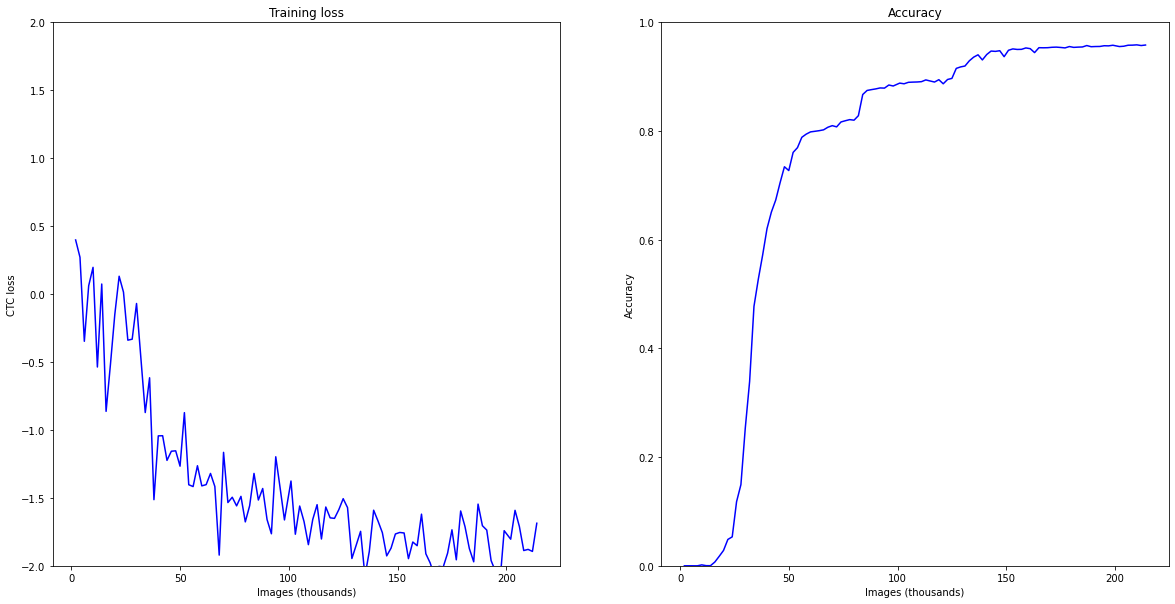

Loss: -1.686819314956665
Accuracy: 0.9579994616494615
Epoch: 11


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].clear()
axes[1].clear()
IPython.display.clear_output(wait=True)
IPython.display.display(fig)
it = 0
iterations = []
accuracy_axis = []
losses_axis = []

# minimal amount of images for plotting
checkpoint = 2000

images_since_save = 0
#start_time = time.perf_counter()


for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_loader):
        net.train()
        net.zero_grad()

        images = images.to(device)
        targets = labels.to(device)
 
        outputs = net(images)
        outputs = outputs.permute(1,0,2)  
        
        input_lengths = torch.IntTensor(batch_size_tr).fill_(90)
        target_lengths = torch.IntTensor([len(t) for t in  targets])
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        outs_decoded = decode_batch(outputs)
 
        loss.backward()
        optimizer.step()
        
        images_since_save += len(images)


        if images_since_save > checkpoint:
            it += images_since_save
            iterations.append(it)
            losses_axis.append(loss.item())
            images_since_save = 0

            print("Computing accuracy...")
            accuracy = compute_accuracy(net, valid_loader, ignore_spaces = ignore_spaces)
            accuracy_axis.append(accuracy)
            iter_axis = np.array(iterations) // 1000

            axes[0].clear()
            axes[0].set(title='Training loss',
                        xlabel='Images (thousands)',ylabel='CTC loss')
            axes[0].set_ylim(ymin=-2, ymax=2)
            axes[0].plot(iter_axis, losses_axis, 'b-')


            axes[1].clear()
            axes[1].set(title='Accuracy',
                        xlabel='Images (thousands)', ylabel='Accuracy')
            axes[1].set_ylim(ymin=0, ymax=1)
            axes[1].plot(iter_axis, accuracy_axis, 'b-')

            IPython.display.clear_output(wait=True)
            IPython.display.display(fig)
            # print("Saved state to checkpoint", fname)
            print("Loss:", loss.item())
            print("Accuracy:", accuracy)
            print("Epoch:", epoch)
            plt.pause(0.005)



In [14]:
if accuracy > expected_accuracy:
    print("Saving the new best result")
    torch.save(net.state_dict(), './models/best_model.pth')

Saving the new best result


# 7. Validation

In [13]:
def model_demonsration(net, valid_loader):

    (images, labels) = next(iter(valid_loader))
    images = images.to(device)
    targets = labels.to(device)
    outputs = net(images)
    outs_decoded = decode_batch(outputs)

    for i in range(labels.shape[0]):
        y_test = numbers_to_text(targets[i])
        y_pred = outs_decoded [i]
        
        plt.imshow(images[i].squeeze(), cmap='gray')
        mpl.rcParams["font.size"] = 12
        plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test))
        plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(y_pred))
        plt.show()
        
    accuracy1 = compute_accuracy(net, valid_loader, ignore_spaces = True)
    accuracy2 = compute_accuracy(net, valid_loader, ignore_spaces = False)
    print ('accuracy (ignore spaces)', accuracy1 )
    print ('accuracy (count spaces)', accuracy2 )
    

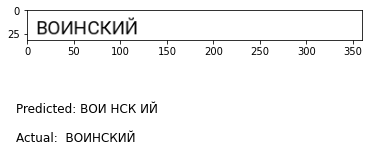

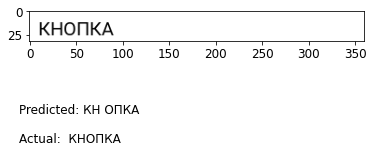

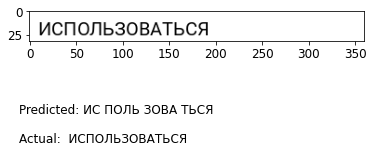

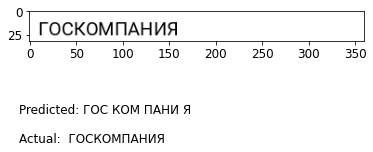

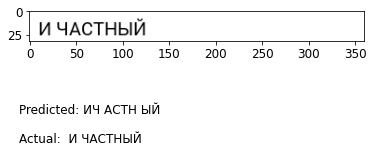

accuracy (ignore spaces) 0.9578508380508379
accuracy (count spaces) 0.70990322017164


In [14]:
model_demonsration(net, valid_loader)